step 1-5

In [2]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data

class Function: # only forward propagation is implemented
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        return output

def forward(self, x):
    raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        return x**2

class Exp(Function):
    def forward(self, x):
        return np.exp(x)

def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data)/(2*eps)

step 6

In [4]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None # save gradient once forward prop finished

In [5]:
class Function:
    def __call__(self, input):
        x = input.data 
        y = self.forward(x)
        output = Variable(y)
        self.input = input # save input, being used in backprop
        return output
    
    def forward(self, x): # to be implemented in each subclass that inherits Function class
        raise NotImplementedError()
        
    def backward(self, gy): #  to be implemented in each subclass that inherits Function class
        raise NotImplementedError()

In [6]:
class Square(Function): # y = x^2
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy): # toss back dy/dx = 2x
        x = self.input.data
        gx = 2 * x * gy
        return gx

In [7]:
class Exp(Function): # y = e^x
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy): # toss back dy/dx = e^x
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [8]:
# Forward prop example

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

#print(y.data)

In [9]:
# Backward prop example

y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

# it works but let's go on automation of process (define by run)

3.297442541400256


Step 7 Automation of back prop (once forward prop is done, procedure of back prop is set automatically)

In [11]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None # variable to remember its mother

    def set_creator(self, func): # method to remember its mother
        self.creator = func

        
class Function: # Function saves its input and output
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y) # output is the son of a mother, so
        output.set_creator(self) # it remembers who is its mother via "set_creator" function
        
        self.input = input
        self.output = output
        
        return output
    
    def forward(self, x): # will be implemented in each subclass that inherits from the parent class
        raise NotImplementedError()
        
    def backward(self, gy): #  will be implemented in each subclass that inherits from the parent class
        raise NotImplementedError()
    

# In a nutshell, 
# Function saves input and ouput
# output saves Function

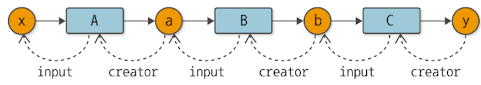

In [37]:
# Structure concept

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))

a = A(x)
b = B(a)
y = C(b)

"""
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x


# simple backward prop example

# calculate gradient at b from y
y.grad = np.array(1.0) # assume gradient at y = 1
C = y.creator # y knows its mother function, C
b = C.input # C knows its input, b
b.grad = C.backward(y.grad) # save gradient at b calculated from C.backward

# calculate gradient at a from b
B = b.creator
a = B.input
a.grad = B.backward(b.grad) 

# calculate gradient at x from a
A = a.creator
x = A.input
x.grad = A.backward(a.grad) 

print(x.grad)

# Still, it's somewhat repititive like B-a-a.grad, A-x-x.grad. Let's make it automatic.
"""

"\nassert y.creator == C\nassert y.creator.input == b\nassert y.creator.input.creator == B\nassert y.creator.input.creator.input == a\nassert y.creator.input.creator.input.creator == A\nassert y.creator.input.creator.input.creator.input == x\n\n\n# simple backward prop example\n\n# calculate gradient at b from y\ny.grad = np.array(1.0) # assume gradient at y = 1\nC = y.creator # y knows its mother function, C\nb = C.input # C knows its input, b\nb.grad = C.backward(y.grad) # save gradient at b calculated from C.backward\n\n# calculate gradient at a from b\nB = b.creator\na = B.input\na.grad = B.backward(b.grad) \n\n# calculate gradient at x from a\nA = a.creator\nx = A.input\nx.grad = A.backward(a.grad) \n\nprint(x.grad)\n\n# Still, it's somewhat repititive like B-a-a.grad, A-x-x.grad. Let's make it automatic.\n"

In [39]:
import numpy as np


class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self): # backward function takes three steps in order
        f = self.creator  # 1. check who is the mother function
        if f is not None:
            x = f.input  # 2. mother knows which one is input
            x.grad = f.backward(self.grad)  # 3. mother is able to calculate gradient at input
            x.backward() # call another backward function until creator==None, which means input==x


In [41]:
# example

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# backprop
y.grad = np.array(1.0)
y.backward() # it backpropagates till the end, x. We get x.grad.
print(x.grad)

None


Step 8

In [44]:
# we called backward function recursively, backward(backward(backward()))
# This time, convert recursive function call to loop structure. why? memory efficiency

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        funcs = [self.creator] # first, put mother function in the list
        while funcs: # while loop instead of recursive function calls
            f = funcs.pop() # take out (remove from the list) and save the mother function in f
            x, y = f.input, f.output # mother knows both input and output
            x.grad = f.backward(y.grad) # calculate gradient at input with gradient at output
            
            if x.creator is not None: # if we find the mother of current input,
                funcs.append(x.creator) # put it in the list and restart the process with it

In [50]:
# example
"""
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# backprop
y.grad = np.array(1.0)
y.backward() # it backpropagates till the end, x. We get x.grad.
print(x.grad)
"""

'\nA = Square()\nB = Exp()\nC = Square()\n\nx = Variable(np.array(0.5))\na = A(x)\nb = B(a)\ny = C(b)\n\n# backprop\ny.grad = np.array(1.0)\ny.backward() # it backpropagates till the end, x. We get x.grad.\nprint(x.grad)\n'

Chapter 9 (make functions deployment and back prop method simple)

In [53]:
#1. rather than creating an instance and using it, we define extra functions as below:

def square(x):
    return Square()(x)

def exp(x):
    return Exp()(x)



In [57]:
# Now, we can code in simple form.
"""
x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)
# or even like y = square(exp(square(x)))

y.grad = np.array(1.0)
y.backward()
print(x.grad)
"""

'\nx = Variable(np.array(0.5))\na = square(x)\nb = exp(a)\ny = square(b)\n# or even like y = square(exp(square(x)))\n\ny.grad = np.array(1.0)\ny.backward()\nprint(x.grad)\n'

In [59]:
#2. remove y.grad = np.array(1.0)

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: # once backward function is called, set initial output gradient (y_grad) is set to 1(s)
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop() 
            x, y = f.input, f.output 
            x.grad = f.backward(y.grad) 
            
            if x.creator is not None: 
                funcs.append(x.creator) 

In [63]:
"""
x = Variable(np.array(0.5)) # input
y = square(exp(square(x))) # output via forward prop
y.backward() # call backward()
print(x.grad)
"""

'\nx = Variable(np.array(0.5)) # input\ny = square(exp(square(x))) # output via forward prop\ny.backward() # call backward()\nprint(x.grad)\n'

In [65]:
# what if user tries to put non-ndarray data into Variable?

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop() 
            x, y = f.input, f.output 
            x.grad = f.backward(y.grad) 
            
            if x.creator is not None: 
                funcs.append(x.creator) 

In [67]:
# example

x = Variable(np.array(1.0))
x = Variable(None)

#x = Variable(1.0) # raise error

In [457]:
# but Python results in float after applying operations on 0-dimension ndarray.
# we need to deal with this issue.

# for make it easy, define a function

def as_array(x):
    if np.isscalar(x): # int and float are scalar
        return np.array(x)
    return x



In [ ]:
class Function: 
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self) 
        
        self.input = input
        self.output = output
        
        return output
    
    def forward(self, x): 
        raise NotImplementedError()
        
    def backward(self, gy): 
        raise NotImplementedError()

Step 10. How to test DL framework?

In [72]:
import unittest

class SquareTest(unittest.TestCase):
    def test_forward(self): # name of method should begin with 'test'
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)
        
    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)
        
    def test_gradient_check(self):
        x = Variable(np.random.rand(1))
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

In [74]:
# python -m unittest steps/step10.py

Step 11

In [168]:
# SISO (single Variable) -> MIMO (list or tuple of Variables)

class Function: 
    def __call__(self, inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self) 
        
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs
    
    def forward(self, xs): 
        raise NotImplementedError()
        
    def backward(self, gys): 
        raise NotImplementedError()

In [178]:
# Add class

class Add(Function):
    def forward(self, xs):
        x0, x1 = xs
        y = x0 + x1
        return (y,)


# example
xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)


AttributeError: 'list' object has no attribute 'data'

Step 12

In [113]:
# Improvement in forward prop
# SISO (single Variable) -> MIMO (list or tuple of Variables)

#1. make it easy to use (not multiple args in list, but independent args)

class Function: 
    def __call__(self, *inputs): # * for variable # of arguments
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self) 
        
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, *xs): 
        raise NotImplementedError()
        
    def backward(self, *gys): 
        raise NotImplementedError()
"""        
# example
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
f = Add()
y = f(x0, x1)
print(y.data)
"""

'        \n# example\nx0 = Variable(np.array(2))\nx1 = Variable(np.array(3))\nf = Add()\ny = f(x0, x1)\nprint(y.data)\n'

In [115]:
#2. make it easy to implement function

class Function: 
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # list unpack: self.forward(*xs) -> self.forward(x0, x1)
        if not isinstance(ys, tuple): # if ys is not a tuple, convert it to tuple form
                ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self) 
        
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs): 
        raise NotImplementedError()
        
    def backward(self, gys): 
        raise NotImplementedError()

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y


In [284]:
# define add function using Add class
def add(x0, x1):
    return Add()(x0, x1)

# example
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

5


Step 13

In [282]:
# Improvement in backward prop
# SISO (single Variable) -> MIMO (list or tuple of Variables)

class Add(Function):
    def forward(self, x0, x1): # two inputs, one output
        y = x0 + x1
        return y
    
    def backward(self, gy): # one input, two outputs
        return gy, gy

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop()
            #x, y = f.input, f.output 
            #x.grad = f.backward(y.grad) 
            gys = [output.grad for output in f.outputs] # save gradients at output(s) in the list, gys
            gxs = f.backward(*gys) # call backprop with above gradients at outpus(s)
            if not isinstance(gxs, tuple): # if gxs is not a tuple,
                gxs = (gxs,) # convert it into a tuple
            
            for x, gx in zip(f.inputs, gxs): # zip matches its arguments in order into tuples
                x.grad = gx # save x's gradient (gx) in x.grad
                
                if x.creator is not None: 
                    funcs.append(x.creator) 

In [205]:
# Edit Square function for MIMO

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy): 
        #x = self.input.data
        x = self.inputs[0].data # Function class has arg named 'inputs'
        gx = 2 * x * gy
        return gx

In [124]:
# example. z = x^2 + y^2

x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()

print(z.data)
print(x.grad)
print(y.grad)

13.0
4.0
6.0


Step 14

In [127]:
# Fixing an issue of using the same var multiple times within a function
# example

x = Variable(np.array(3.0))
y = add(x, x)
print('y', y.data)

y.backward()
print('x.grad', x.grad) # answer is two

y 6.0
x.grad 1.0


In [129]:
# the output above is wrong
# need to edit code so that values are accumulated if we use the same var multiple times

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop()
            gys = [output.grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: # have not assigned gradient to a var, 
                    x.grad = gx # assign the gradient 
                else: # if var has gradient already, but it was used further at the same time,
                    x.grad = x.grad + gx # accumulate gradient
                    
                if x.creator is not None: 
                    funcs.append(x.creator) 

In [131]:
# example

x = Variable(np.array(3.0))
y = add(x, x)
print('y', y.data)

y.backward()
print('x.grad', x.grad) # answer is two

y 6.0
x.grad 2.0


In [133]:
# We have another issue here so far.
# We resolved the issue of using the same var multiple times within a function, but what if we use a var multiple times across various functions?

x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

y = add(add(x, x), x)
y.backward()
print(x.grad) # answer is 3

2.0
5.0


In [135]:
# we define a function to reset gradient once calculations for a function is done

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop()
            gys = [output.grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    funcs.append(x.creator) 
    
    def cleargrad(self):
        self.grad = None # reset gradient

In [137]:
# example

x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

x.cleargrad()
y = add(add(x, x), x)
y.backward()
print(x.grad)

2.0
3.0


Step 16

In [140]:
# segment generation so that backprop goes back level by level


class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # to identify generation

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # set one generation plus from its mother

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator] 
        while funcs: 
            f = funcs.pop()
            gys = [output.grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    funcs.append(x.creator) 
    
    def cleargrad(self):
        self.grad = None

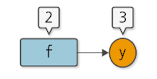

In [143]:
# apply to Function

class Function: 
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # list unpack: self.forward(*xs) -> self.forward(x0, x1)
        if not isinstance(ys, tuple): # if ys is not a tuple, convert it to tuple form
                ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs]) # generation of a function is max(generation of inputs)
        
        for output in outputs:
            output.set_creator(self) 
        
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs): 
        raise NotImplementedError()
        
    def backward(self, gys): 
        raise NotImplementedError()

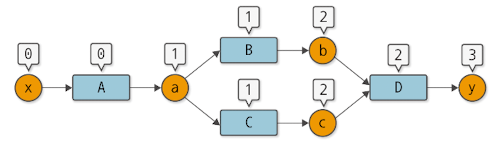

In [146]:
# Now, once we've done sort generation, backprop could be done in order.

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # set one generation plus from its mother

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] # functions list
        seen_set = set() # list of functions dealt with

        def add_func(f): # instead of .append, new function for add & sort at the same time
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # so, pop() lifts the largest number

        add_func(self.creator)
        
        #funcs = [self.creator] 
        while funcs: 
            f = funcs.pop()
            gys = [output.grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    #funcs.append(x.creator) 
                    add_func(x.creator)
    
    def cleargrad(self):
        self.grad = None

Step 17 Performance Enhancement

In [186]:
# Reference count is one of the way Python handles memory management. But, it doesn't work for circular reference. 
# So, Garbage Collection is here to handle various cases including circular reference. But, it takes time to get rid of unused items.
# Let's make it a weak reference, i.e. reference as usual but without reference count increase.

import weakref

class Function: 
    def __init__(self):
        self.generation = 0
    
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # list unpack: self.forward(*xs) -> self.forward(x0, x1)
        if not isinstance(ys, tuple): # if ys is not a tuple, convert it to tuple form
                ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs]) # generation of a function is max(generation of inputs)
        
        for output in outputs:
            output.set_creator(self) 
        
        self.inputs = inputs
        #self.outputs = outputs
        self.outputs = [weakref.ref(output) for output in outputs] # self.outputs refer data in a weak reference form
        
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs): 
        raise NotImplementedError()
        
    def backward(self, gys): 
        raise NotImplementedError()


class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 

    def backward(self):
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] 
        seen_set = set() 

        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) 

        add_func(self.creator)
        
        while funcs: 
            f = funcs.pop()
            #gys = [output.grad for output in f.outputs] 
            gys = [output().grad for output in f.outputs] # need () to access the data it refers
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    add_func(x.creator)
    
    def cleargrad(self):
        self.grad = None

Step 18 Save Memory

In [189]:
# 1. Delete unnecessary derivatives results immediately
# 2. Reserve a mode without backprop

In [191]:
# example

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

1.0 1.0
2.0 1.0


In [195]:
# 1. So far, we had all var save its gradient.
# But what we focus on is gradients at inputs, not interim variables.
# Let's make variables in the middle miss their gradients.

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 

    def backward(self, retain_grad=False): # variable to check if all gradients need to be saved
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] 
        seen_set = set() 

        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) 

        add_func(self.creator)
        
        while funcs: 
            f = funcs.pop()
            gys = [output().grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None # y is a weak reference, so y(). None will get it deleted from memory (reference count equals 0)
    
    def cleargrad(self):
        self.grad = None



In [199]:
# example
# Now, we delete all grad except for x0 and x1.

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

None None
2.0 1.0


In [201]:
# We need forward prop results to do back prop. So, each result (inputs to functions) must be retained till back prop.
# Unlike ML, inference is only a process of forward prop. So, we don't need to keep all data in the middle.

# Here comes the mode without back prop!

class Config:
    enable_backprop = True

class Function: 
    def __init__(self):
        self.generation = 0
    
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
                ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop: # Everything required for backpropagation is contained within the if statement
            self.generation = max([x.generation for x in inputs]) 
        
            for output in outputs:
                output.set_creator(self) 
            
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs] 
            
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs): 
        raise NotImplementedError()
        
    def backward(self, gys): 
        raise NotImplementedError()


In [211]:
Config.enable_backprop = True # for ML
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))
y.backward()

Config.enable_backprop = False # for inference
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))

In [215]:
# mode conversion with 'with'

import contextlib

@contextlib.contextmanager # This decorator tells this function should be treated as a context manager
def using_config(name, value): # name of the attribute on the Config object you want to temporarily change, new value to assign to that attribute during the context
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield # The yield statement temporarily suspends the function and transfers control back to the caller
    finally:
        setattr(Config, name, old_value) # Once the with block finishes, the code in the finally block is executed. resets the attribute on Config back to its original value.

In [217]:
# example

with using_config('enable_backprop', False):
    x = Variable(np.array(2.0))
    y = square(x)

In [219]:
# but I am a sloth who doesn't want to type with statement everytime, so

def no_grad():
    return using_config('enable_backprop', False)

# it's better!
with no_grad():
    x = Variable(np.array(2.0))
    y = square(x)

Step 19. Let's use Variable class in an easy way

In [222]:
class Variable:
    def __init__(self, data, name=None): # I have a name from now on
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.name = name # now Variable has name
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 

    def backward(self, retain_grad=False): 
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] 
        seen_set = set() 

        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) 

        add_func(self.creator)
        
        while funcs: 
            f = funcs.pop()
            gys = [output().grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 
    
    def cleargrad(self):
        self.grad = None



In [228]:
# Let's make Variable look like ndarray

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.name = name 
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 

    def backward(self, retain_grad=False): 
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] 
        seen_set = set() 

        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) 

        add_func(self.creator)
        
        while funcs: 
            f = funcs.pop()
            gys = [output().grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

    def cleargrad(self):
        self.grad = None

    @property # make shape function as if it is an instance variable
    def shape(self): # define shape function
        return self.data.shape

In [230]:
# example

x = Variable(np.array([[1,2,3],[4,5,6]]))
print(x.shape) # .shape works thanks to @property

(2, 3)


In [387]:
# let's add other variables further

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.name = name 
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 

    def backward(self, retain_grad=False): 
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] 
        seen_set = set() 

        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) 

        add_func(self.creator)
        
        while funcs: 
            f = funcs.pop()
            gys = [output().grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

    def cleargrad(self):
        self.grad = None

    @property 
    def shape(self): 
        return self.data.shape

    @property 
    def ndim(self): # # of dimension
        return self.data.ndim

    @property 
    def size(self): # # of elements
        return self.data.size

    @property 
    def dtype(self): # data type
        return self.data.dtype

    def __len__(self): # show the length of Variable instance
        return len(self.data)

    def __repr__(self): # make print work following my taste
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

Step 20 '+' and '*' workable for Variable directly via operator overload

In [417]:
# '*' first

class Mul(Function): # define forward and backward prop function
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy*x1, gy*x0

def mul(x0, x1): # make multiplication work with mul()
    return Mul()(x0, x1)

In [419]:
# example

a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = add(mul(a,b), c)

y.backward()

print(y)
print(a.grad)
print(b.grad)

AttributeError: 'NoneType' object has no attribute 'generation'

In [477]:
# rather than applying 'add' or 'mul', what about using '+' or '*'?
# we go with operator overload

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported.'.format(type(data)))
        
        self.data = data
        self.name = name 
        self.grad = None
        self.creator = None
        self.generation = 0 

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 

    def backward(self, retain_grad=False): 
        if self.grad is None: 
            self.grad = np.ones_like(self.data)

        funcs = [] 
        seen_set = set() 

        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) 

        add_func(self.creator)
        
        while funcs: 
            f = funcs.pop()
            gys = [output().grad for output in f.outputs] 
            gxs = f.backward(*gys) 
            if not isinstance(gxs, tuple): 
                gxs = (gxs,) 
            
            for x, gx in zip(f.inputs, gxs): 
                if x.grad is None: 
                    x.grad = gx
                else: 
                    x.grad = x.grad + gx 
                    
                if x.creator is not None: 
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None 

    def cleargrad(self):
        self.grad = None

    @property 
    def shape(self): 
        return self.data.shape

    @property 
    def ndim(self): 
        return self.data.ndim

    @property 
    def size(self):
        return self.data.size

    @property 
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def __mul__(self, other):
        return mul(self, other)

In [396]:
# there is another simple way to do it. :(

Variable.__mul__ = mul
Variable.__add__ = add

In [398]:
# example

a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
y = a * b
print(y)

# same calculation above
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

#y = add(mul(a,b), c)
y = a * b + c

y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(6.0)


AttributeError: 'NoneType' object has no attribute 'generation'

Step 21 make it possible to do operations like Variable * ndarray or Variable + 3

In [463]:
# how can we make Variable * np.array(2.0) workable?
# have np.array wear Variable dress!

def as_variable(obj): # this function makes obj a Variable
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

class Function: 
    def __init__(self):
        self.generation = 0
    
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs] # convert all elements in inputs into Variable with as_variable()
        
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
                ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop: 
            self.generation = max([x.generation for x in inputs]) 
        
            for output in outputs:
                output.set_creator(self) 
            
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs] 
            
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs): 
        raise NotImplementedError()
        
    def backward(self, gys): 
        raise NotImplementedError()



In [465]:
# example

x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

variable(5.0)


In [481]:
# what about Variable + 3.0?

def add(x0, x1):
    x1 = as_array(x1) # ex. int/float -> ndarray
    return Add()(x0, x1) # ndarray -> Variable

In [483]:
# example

x = Variable(np.array(2.0))
y = x + 3.0
print(y)

TypeError: unsupported operand type(s) for +: 'Variable' and 'float'

In [485]:
# What if int/float is on the left of the operator?
# __mul__ for the left one, and __rmul__ for the right one. 
# Let's define __rmul__ as well so that int/float can be placed on left or right.

# add and mul are interoperable, so just assign the same function for reverse function. (__r __)
Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

In [487]:
# example

x = Variable(np.array(2.0))
y = 3.0 * x + 1.0
print(y)

TypeError: <class 'float'> is not supported.

Step 22 Add more operators 

In [492]:
# Negate

class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy

def neg(x):
    return Neg()(x)

Variable.__neg__ = neg


In [494]:
# example

x = Variable(np.array(2.0))
y = -x
print(y)

variable(-2.0)


In [498]:
# Subtraction

class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy

def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)

Variable.__sub__ = sub

In [502]:
def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)

Variable.__rsub__ = rsub

In [504]:
# example

x = Variable(np.array(2.0))
y1 = 2.0 - x
y2 = x - 1.0
print(y1)
print(y2)

variable(0.0)
variable(1.0)


In [506]:
# Division

class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1

def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)

def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)

Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv


In [510]:
# power

class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c
        gx = c * x ** (c - 1) * gy
        return gx

def pow(x, c):
    return Pow(c)(x)

Variable.__pow__ = pow

In [512]:
# example

x = Variable(np.array(2.0))
y = x ** 3
print(y)

variable(8.0)
